In [68]:
!pip install torch torch_geometric torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=cd3bf6f77a0995d752232e271adaef8b915763ede576cbb3abda3faba9397c23
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [36]:
%matplotlib inline

import json
import collections
import numpy as np
import pandas as pd
import requests

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit as masking
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv

import networkx as nx

In [13]:
url = "https://raw.githubusercontent.com/yulin09/SocialNetworkAnalysis/main/deezer_europe/deezer_europe_features.json"
response = requests.get(url)
data_raw = json.loads(response.text)
edges=pd.read_csv("https://raw.githubusercontent.com/yulin09/SocialNetworkAnalysis/main/deezer_europe/deezer_europe_edges.csv")
target_df=pd.read_csv("https://raw.githubusercontent.com/yulin09/SocialNetworkAnalysis/main/deezer_europe/deezer_europe_target.csv")

feats = [len(features) for features in data_raw.values()]  # List of feature lengths per node
feat_counts = [len(set(features)) for features in data_raw.values()]  # Count of unique features per node

print("5 top nodes labels")
print(target_df.head(5).to_markdown())
print()
print("5 last nodes")
print(target_df.tail(5).to_markdown())

5 top nodes labels
|    |   id |   target |
|---:|-----:|---------:|
|  0 |    0 |        0 |
|  1 |    1 |        0 |
|  2 |    2 |        0 |
|  3 |    3 |        1 |
|  4 |    4 |        0 |

5 last nodes
|       |    id |   target |
|------:|------:|---------:|
| 28276 | 28276 |        0 |
| 28277 | 28277 |        1 |
| 28278 | 28278 |        0 |
| 28279 | 28279 |        1 |
| 28280 | 28280 |        1 |


In [31]:
def encode_data(light=False, n=60):
    if light:
        nodes_included = n
    else:
        nodes_included = len(data_raw)

    data_encoded = {}
    for i in range(nodes_included):
        one_hot_feat = np.array([0] * (max(feats) + 1))
        this_feat = data_raw[str(i)]

        # Handle the case where this_feat is a list
        if isinstance(this_feat, list):
            valid_feats = [feat for feat in this_feat if isinstance(feat, int) and 0 <= feat < len(one_hot_feat)]
            for feat in valid_feats:
                one_hot_feat[feat] = 1

            if len(valid_feats) < len(this_feat):
                None
        else:
            # Handle the case where this_feat is a single integer
            if isinstance(this_feat, int) and 0 <= this_feat < len(one_hot_feat):
                one_hot_feat[this_feat] = 1
            else:
                None

        data_encoded[str(i)] = list(one_hot_feat)

    if light:
        sparse_feat_matrix = np.zeros((1, max(feats) + 1))
        for j in range(nodes_included):
            temp = np.array(data_encoded[str(j)]).reshape(1, -1)
            sparse_feat_matrix = np.concatenate((sparse_feat_matrix, temp), axis=0)
        sparse_feat_matrix = sparse_feat_matrix[1:, :]
        return data_encoded, sparse_feat_matrix
    else:
        return data_encoded, None


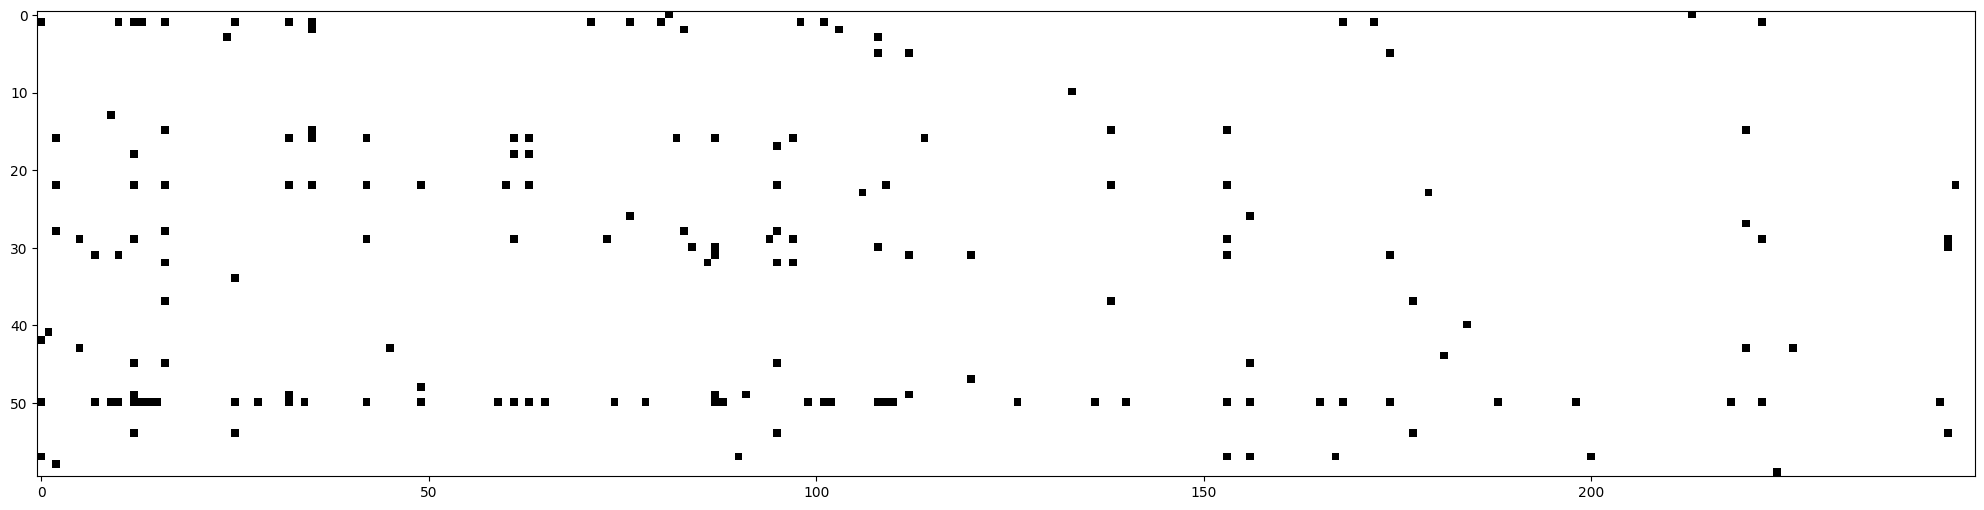

In [32]:
data_encoded_vis,sparse_feat_matrix_vis=encode_data(light=True,n=60)
plt.figure(figsize=(25,25));
plt.imshow(sparse_feat_matrix_vis[:,:250],cmap='Greys');

In [27]:
def construct_graph(data_encoded,light=False):
    node_features_list=list(data_encoded.values())
    node_features=torch.tensor(node_features_list)
    node_labels=torch.tensor(target_df['target'].values)
    edges_list=edges.values.tolist()
    edge_index01=torch.tensor(edges_list, dtype = torch.long).T
    edge_index02=torch.zeros(edge_index01.shape, dtype = torch.long)#.T
    edge_index02[0,:]=edge_index01[1,:]
    edge_index02[1,:]=edge_index01[0,:]
    edge_index0=torch.cat((edge_index01,edge_index02),axis=1)
    g = Data(x=node_features, y=node_labels, edge_index=edge_index0)
    g_light = Data(x=node_features[:,0:2],
                     y=node_labels   ,
                     edge_index=edge_index0[:,:55])
    if light:
        return(g_light)
    else:
        return(g)

In [28]:
def draw_graph(data0):
    #node_labels=data0.y
    if data0.num_nodes>100:
        print("This is a big graph, can not plot...")
        return

    else:
        data_nx = to_networkx(data0)
        node_colors=data0.y[list(data_nx.nodes)]
        pos= nx.spring_layout(data_nx,scale =1)
        plt.figure(figsize=(12,8))
        nx.draw(data_nx, pos,  cmap=plt.get_cmap('Set1'),
                node_color =node_colors,node_size=600,connectionstyle="angle3",
                width =1, with_labels = False, edge_color = 'k', arrowstyle = "-")

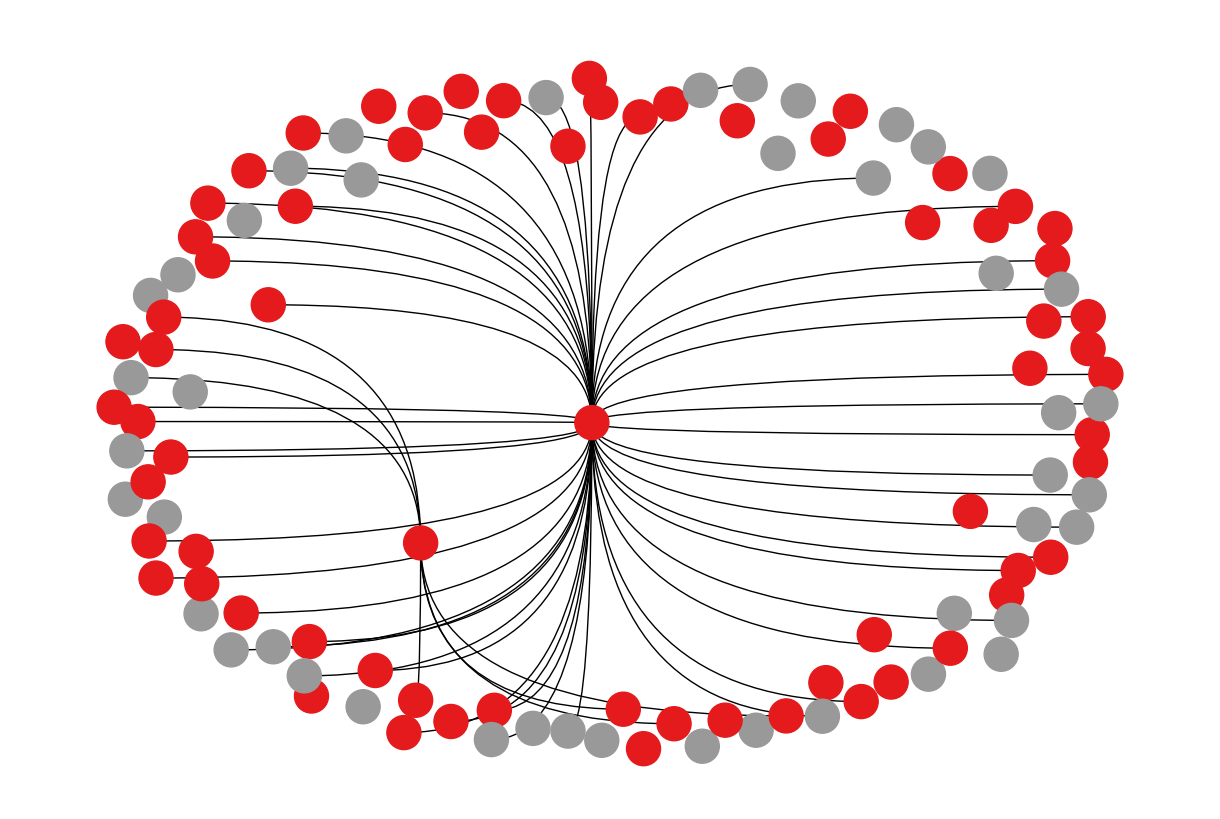

In [29]:
g_sample=construct_graph(data_encoded=data_encoded_vis,light=True)
draw_graph(g_sample)

In [39]:
data_encoded,_=encode_data(light=False)
g=construct_graph(data_encoded=data_encoded,light=False)

In [40]:
msk=masking(split="train_rest", num_splits = 1, num_val = 0.3, num_test= 0.6)
g=msk(g)
print(g)
print()
print("training samples",torch.sum(g.train_mask).item())
print("validation samples",torch.sum(g.val_mask ).item())
print("test samples",torch.sum(g.test_mask ).item())

Data(x=[28281, 1716], edge_index=[2, 185504], y=[28281], train_mask=[28281], val_mask=[28281], test_mask=[28281])

training samples 2828
validation samples 8484
test samples 16969


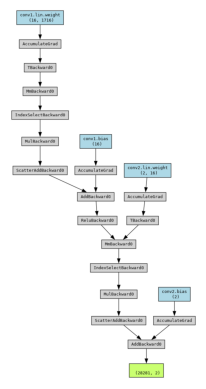

<Figure size 640x480 with 0 Axes>

In [74]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torchviz import make_dot
import matplotlib.pyplot as plt

class SocialGNN(torch.nn.Module):
    def __init__(self, num_of_feat, f):
        super(SocialGNN, self).__init__()
        self.conv1 = GCNConv(num_of_feat, f)
        self.conv2 = GCNConv(f, 2)

    def forward(self, data):
        x = data.x.float()
        edge_index = data.edge_index
        x = self.conv1(x=x, edge_index=edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

num_of_feat = g.num_node_features
net = SocialGNN(num_of_feat=num_of_feat, f=16)

def visualize_model(model, data):
    model.eval()
    out = model(data)
    dot = make_dot(out, params=dict(model.named_parameters()))
    dot.format = 'png'
    dot.render('model_visualization')

visualize_model(net, g)

img = plt.imread('model_visualization.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [42]:
def masked_loss(predictions,labels,mask):
    mask=mask.float()
    mask=mask/torch.mean(mask)
    loss=criterion(predictions,labels)
    loss=loss*mask
    loss=torch.mean(loss)
    return (loss)    

def masked_accuracy(predictions,labels,mask):
    mask=mask.float()
    mask/=torch.mean(mask)
    accuracy=(torch.argmax(predictions,axis=1)==labels).long()
    accuracy=mask*accuracy
    accuracy=torch.mean(accuracy)
    return (accuracy)

In [54]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(predictions, labels, mask):
    pred_labels = predictions[mask].argmax(dim=1).detach().cpu().numpy()
    true_labels = labels[mask].detach().cpu().numpy()

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)

    return accuracy, precision, recall, f1

def train_social(net, data, epochs=1000, lr=0.01):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    best_accuracy = 0.0

    train_losses = []
    train_accuracies = []

    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []

    test_losses = []
    test_accuracies = []
    test_precisions = []
    test_recalls = []
    test_f1s = []

    for ep in range(epochs + 1):
        optimizer.zero_grad()
        out = net(data)
        
        loss = masked_loss(predictions=out,
                           labels=data.y,
                           mask=data.train_mask)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.detach().cpu().numpy())
        train_accuracy = masked_accuracy(predictions=out,
                                         labels=data.y,
                                         mask=data.train_mask)
        train_accuracies.append(train_accuracy.detach().cpu().numpy())

        val_loss = masked_loss(predictions=out,
                               labels=data.y,
                               mask=data.val_mask)
        val_losses.append(val_loss.detach().cpu().numpy())

        val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(out, data.y, data.val_mask)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        test_loss = masked_loss(predictions=out,
                                labels=data.y,
                                mask=data.test_mask)
        test_losses.append(test_loss.detach().cpu().numpy())

        test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(out, data.y, data.test_mask)
        test_accuracies.append(test_accuracy)
        test_precisions.append(test_precision)
        test_recalls.append(test_recall)
        test_f1s.append(test_f1)

        if np.round(val_accuracy, 4) > np.round(best_accuracy, 4):
            print("Epoch {}/{}, Train_Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}, Val_Precision: {:.4f}, Val_Recall: {:.4f}, Val_F1: {:.4f}, Test_Accuracy: {:.4f}, Test_Precision: {:.4f}, Test_Recall: {:.4f}, Test_F1: {:.4f}"
                  .format(ep + 1, epochs, loss.item(), train_accuracy.item(), val_accuracy, val_precision, val_recall, val_f1, test_accuracy, test_precision, test_recall, test_f1))
            best_accuracy = val_accuracy

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.subplot(2, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.subplot(2, 2, 3)
    plt.plot(val_precisions, label='Validation Precision')
    plt.plot(val_recalls, label='Validation Recall')
    plt.plot(val_f1s, label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.title('Validation Metrics over Epochs')

    plt.subplot(2, 2, 4)
    plt.plot(test_precisions, label='Test Precision')
    plt.plot(test_recalls, label='Test Recall')
    plt.plot(test_f1s, label='Test F1')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.title('Test Metrics over Epochs')

    plt.tight_layout()
    plt.show()


In [63]:
num_of_feat=g.num_node_features
net=SocialGNN(num_of_feat=num_of_feat,f=16)
criterion=nn.CrossEntropyLoss()
# print(net)

SocialGNN(
  (conv1): GCNConv(1716, 16)
  (conv2): GCNConv(16, 2)
)


Epoch 1/1500, Train_Loss: 0.6937, Train_Accuracy: 0.4816, Val_Accuracy: 0.4853, Val_Precision: 0.5027, Val_Recall: 0.4853, Val_F1: 0.4800, Test_Accuracy: 0.4816, Test_Precision: 0.5014, Test_Recall: 0.4816, Test_F1: 0.4762
Epoch 2/1500, Train_Loss: 0.6872, Train_Accuracy: 0.5608, Val_Accuracy: 0.5530, Val_Precision: 0.3059, Val_Recall: 0.5530, Val_F1: 0.3939, Test_Accuracy: 0.5578, Test_Precision: 0.3111, Test_Recall: 0.5578, Test_F1: 0.3994
Epoch 6/1500, Train_Loss: 0.6787, Train_Accuracy: 0.5608, Val_Accuracy: 0.5533, Val_Precision: 0.7529, Val_Recall: 0.5533, Val_F1: 0.3944, Test_Accuracy: 0.5581, Test_Precision: 0.6982, Test_Recall: 0.5581, Test_F1: 0.4003
Epoch 7/1500, Train_Loss: 0.6767, Train_Accuracy: 0.5615, Val_Accuracy: 0.5536, Val_Precision: 0.5828, Val_Recall: 0.5536, Val_F1: 0.3969, Test_Accuracy: 0.5590, Test_Precision: 0.6274, Test_Recall: 0.5590, Test_F1: 0.4037
Epoch 8/1500, Train_Loss: 0.6744, Train_Accuracy: 0.5619, Val_Accuracy: 0.5559, Val_Precision: 0.6141, Val_R

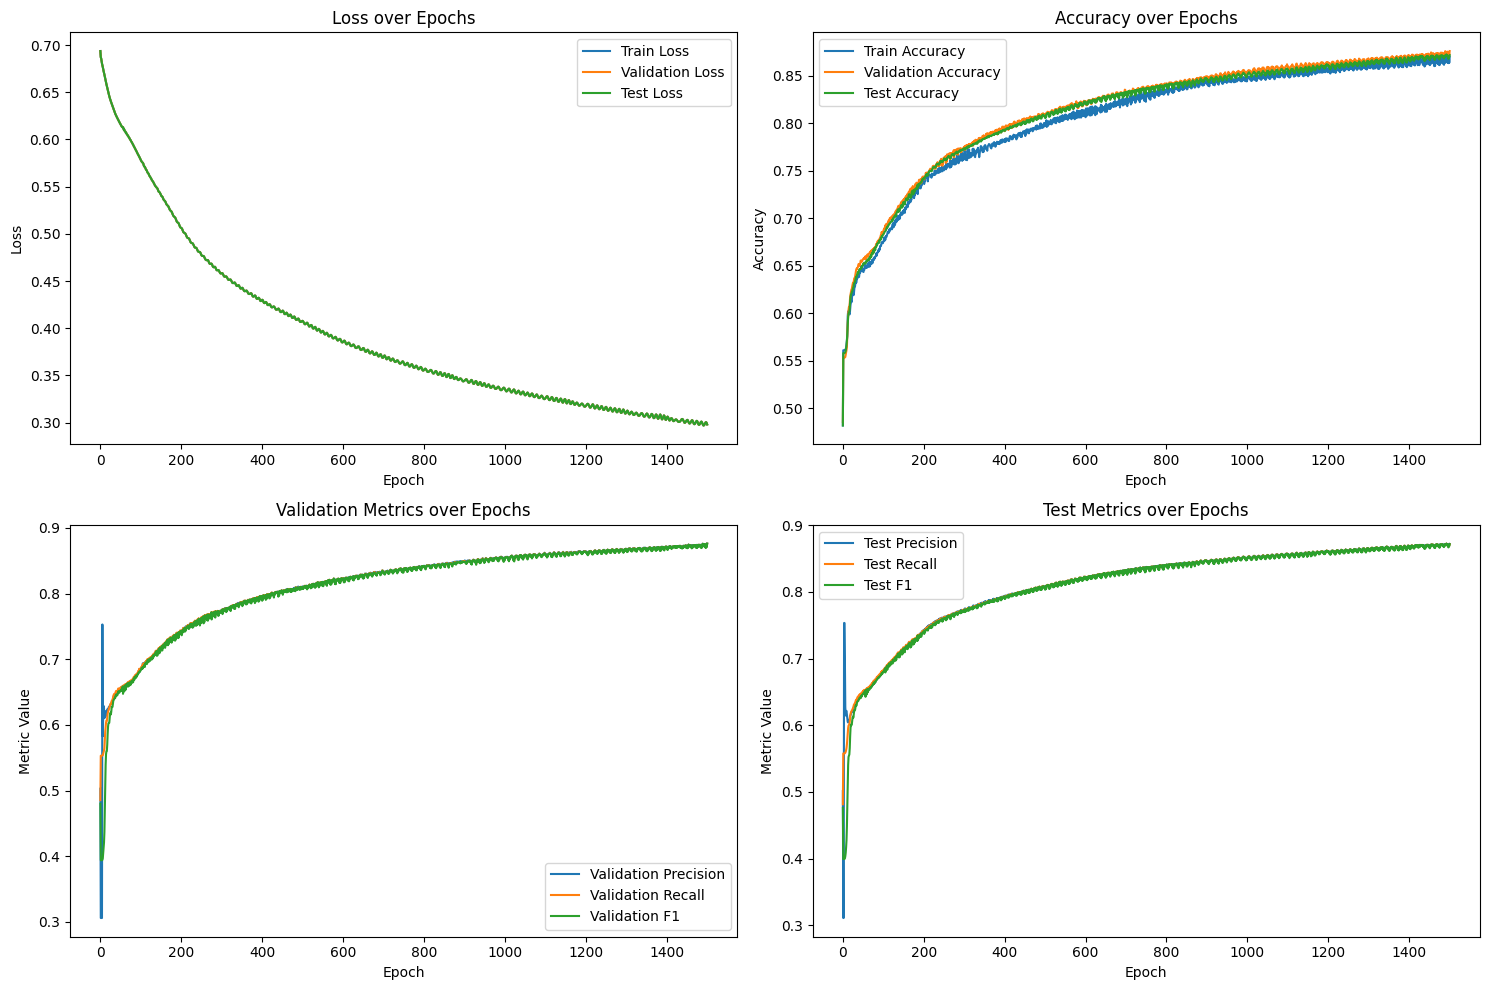

In [62]:
train_social(net,g,epochs=1500,lr=0.01)